In [7]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt

As is mentioned in the readme file, gradient descent is an optimization method that is used by many machine learning algorithms to minimize the loss function, as long as the loss function is differentiable.

For example, it is relatively to do gradient descent for linear regression, as the loss function is mean squared error.

Here I tried to build a 3-layer neural network with gradient descent (specifically, in neural network it is usually called back propagation). It involves chain rule and it is relatively hard to code.

The model is then applied on a make_moons dataset from sklearn.

It is a relatively simple dataset, so the step size in the gradient descent is fixed at epsilon. For complex problems, adjusting the step size during the training process and using momentum are usually helpful.

Steps related to gradient descent are in the backprop function and in the fit_model function (update the weights).

In [ ]:
def generate_data():
    '''
    generate data
    return: X: input data, y: given labels
    '''
    np.random.seed(0)
    X, y = datasets.make_moons(200, noise=0.20)
    return X, y

In [8]:
def plot_decision_boundary(pred_func, X, y):
    '''
    plot the decision boundary
    Params:
    pred_func: function used to predict the label
    X: input data
    y: given labels
    '''
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    #plt.show()


class NeuralNetwork(object):
    """
    This class builds and trains a neural network
    """
    
    def __init__(self, nn_input_dim, nn_hidden_dim, nn_output_dim, actFun_type='tanh', reg_lambda=0.01, seed=0):
        '''
        params:
        nn_input_dim: input dimension
        nn_hidden_dim: the number of hidden units
        nn_output_dim: output dimension
        actFun_type: type of activation function. 3 options: 'tanh', 'sigmoid', 'relu'
        reg_lambda: regularization coefficient
        seed: random seed
        '''
        self.nn_input_dim = nn_input_dim
        self.nn_hidden_dim = nn_hidden_dim
        self.nn_output_dim = nn_output_dim
        self.actFun_type = actFun_type
        self.reg_lambda = reg_lambda
        
        # initialize the weights and biases in the network
        np.random.seed(seed)
        self.W1 = np.random.randn(self.nn_input_dim, self.nn_hidden_dim) / np.sqrt(self.nn_input_dim)
        self.b1 = np.zeros((1, self.nn_hidden_dim))
        self.W2 = np.random.randn(self.nn_hidden_dim, self.nn_output_dim) / np.sqrt(self.nn_hidden_dim)
        self.b2 = np.zeros((1, self.nn_output_dim))
    
    def actFun(self, z, type):
        '''
        actFun computes the activation functions
        Params:
        z: net input
        type: Tanh, Sigmoid, or ReLU
        return: activations
        '''
      
        if type == 'Sigmoid':
            return 1 / (1 + np.exp(-z))
        if type == 'Tanh':
            return np.tanh(z)
        if type == 'ReLu':
            return np.maximum(0, z)
        else:
            raise Exception('Activation function not valid.')
        
        return None
    
    def diff_actFun(self, z, type):
        '''
        diff_actFun computes the derivatives of the activation functions wrt the net input
        Params:
        z: net input
        type: Tanh, Sigmoid, or ReLU
        return: the derivatives of the activation functions wrt the net input
        '''
      
        if type == 'Sigmoid':
            sig = 1. / (1. + np.exp(-z))
            return sig * (1-sig)
        if type == 'Tanh':
            return 1 - np.square(np.tanh(z))
        if type == 'ReLu':
            return np.where(z > 0, 1, 0)
        else:
            raise Exception('Activation function not valid.')
        return None
    
    def feedforward(self, X, actFun):
        '''
        feedforward builds a 3-layer neural network and computes the two probabilities,
        one for class 0 and one for class 1
        Params:
        X: input data
        actFun: activation function
        '''
        
        self.z1 = np.matmul(X, self.W1) + self.b1
        self.a1 = self.actFun(self.z1, self.actFun_type)
        self.z2 = np.matmul(self.a1, self.W2) + self.b2
        exp_scores = np.exp(self.z2)
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return None
    
    def calculate_loss(self, X, y):
        '''
        calculate_loss computes the loss for prediction
        Params:
        X: input data
        param y: given labels
        return: the loss for prediction
        '''
        num_examples = len(X)
        self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))

        # Calculating the loss
        data_loss = np.sum(-np.log(self.probs[range(num_examples), y]))
        
        # Add regulatization term to loss (optional)
        data_loss += self.reg_lambda / 2 * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))
        return (1. / num_examples) * data_loss
    
    def predict(self, X):
        '''
        predict infers the label of a given data point X
        Params:
        X: input data
        return: label inferred
        '''
        self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
        return np.argmax(self.probs, axis=1)
    
    def backprop(self, X, y):
        '''
        backprop implements backpropagation to compute the gradients used to update the parameters in the backward steps
        Params:
        X: input data
        y: given labels
        return: dL/dW1, dL/b1, dL/dW2, dL/db2
        '''
      
        num_examples = len(X)
        delta3 = self.probs
        delta3[range(num_examples), y] -= 1
        dZ2 = delta3
        
        # dW2 is 5*n n*2 -> 5*2
        dW2 = np.matmul(self.a1.T, dZ2)
        # db2 = dL/db2, db2 is 1*2
        db2 = np.sum(dZ2, axis = 0, keepdims = True)
        # dW1 = dL/dW1, dW1 is 2*5
        # dA1 is n*2 2*5 -> n*5
        dA1 = np.matmul(dZ2, self.W2.T)
        # element wise
        # dZ1 is n*5 n*5 -> n*5
        dZ1 = np.multiply(dA1, self.diff_actFun(self.z1, self.actFun_type))
        #dW1 is 2*n n*5 -> 2*5
        dW1 = np.matmul(X.T, dZ1)
        # db1 = dL/db1, db1 is 1*5
        db1 = np.sum(dZ1, axis = 0).reshape(1, self.nn_hidden_dim)
        
        return dW1, dW2, db1, db2
    
    def fit_model(self, X, y, epsilon=0.01, num_passes=20000, print_loss=True):
      """
      fit_model uses backpropagation to train the network
      Params:
      X: input data
      y: given labels
      num_passes: the number of times that the algorithm runs through the whole dataset
      print_loss: print the loss or not
      """
      for i in range(0, num_passes):
          # Forward propagation
          self.feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
          # Backpropagation
          dW1, dW2, db1, db2 = self.backprop(X, y)
          # Add regularization terms (b1 and b2 don't have regularization terms)
          dW2 += self.reg_lambda * self.W2
          dW1 += self.reg_lambda * self.W1
            
          # Gradient descent parameter update
          self.W1 += -epsilon * dW1
          self.b1 += -epsilon * db1
          self.W2 += -epsilon * dW2
          self.b2 += -epsilon * db2

          # Optionally print the loss.
          # This is expensive because it uses the whole dataset, so we don't want to do it too often.
          if print_loss and i % 5000 == 0:
              print("Loss after iteration %i: %f" % (i, self.calculate_loss(X, y)))

    def visualize_decision_boundary(self, X, y):
      '''
      visualize_decision_boundary plots the decision boundary created by the trained network
      '''
      plot_decision_boundary(lambda x: self.predict(x), X, y)

Loss after iteration 0: 0.432387
Loss after iteration 5000: 0.070751
Loss after iteration 10000: 0.070758
Loss after iteration 15000: 0.070758


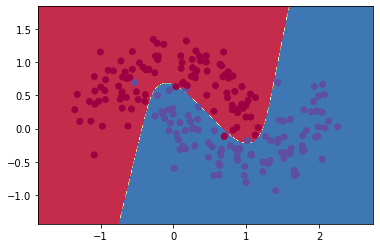

In [9]:
# generate and visualize Make-Moons dataset
X, y = generate_data()
#plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
#plt.show()
    
model = NeuralNetwork(nn_input_dim=2, nn_hidden_dim=3, nn_output_dim=2, actFun_type='Tanh')
model.fit_model(X,y)
model.visualize_decision_boundary(X,y)